In [1]:
from typing import Dict, Tuple
import pandas as pd
import csv
import json
import os
import sys
from pylab import *


sys.path.append("../")
import numpy as np
from serial_broker.Conversion import (
    voltage2force,
    VoltageToForceParameters,
    ParameterManager,
    AmplifierManager,
)
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
from scipy import signal
import seaborn as sns

In [2]:
def get_section_info() -> Dict[str, str]:
    res = {}
    try:
        with open("../manifests/section.csv", newline="") as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                block = str(row["block"])
                start_x = int(row["start_x"])
                start_y = int(row["start_y"])
                end_x = int(row["end_x"])
                end_y = int(row["end_y"])
                res[block] = (start_x, end_x, start_y, end_y)
        return res
    except Exception as e:
        print("error reading from csv file")
        raise e

def parse_file(path):
    res = []
    try:
        with open(path, "r") as f:
            while True:
                jline = f.readline()
                if not jline:
                    break
                res.append(json.loads(jline))
        return res
    except Exception as e:
        print("error reading from jsonl file")
        raise e


def custom_mapping_fn(x: np.ndarray):
    x[6][37] = x[6][38]
    return np.array(x)


In [3]:
section_info = get_section_info()
SURFACE = 1.9625e-5
ARRAY_SIZE = (24, 48)
# Init Calibration
M = ParameterManager()
M.read_from_csv("../manifests/calibration.csv")
C = M.params

# Init Amplifier
amp = AmplifierManager()
amp.read_from_csv("../manifests/amplifier.csv")
K = amp.get()

In [4]:
def split_raw_data(raw_data, section_info: Dict[str, Tuple[int, int, int, int]]):
    splited = {
        k: np.empty(shape=(len(raw_data), v[1] - v[0], v[3] - v[2]))
        for k, v in section_info.items()
    }
    timestamp = np.empty(len(raw_data))
    index = np.empty(len(raw_data), dtype=np.int64)
    total = np.empty(shape=(len(raw_data), *ARRAY_SIZE))
    for idx, dp in enumerate(raw_data):
        timestamp[idx] = dp["ts"]
        index[idx] = dp["index"]

        dp_data = np.array(dp["data"])
        dp_data = custom_mapping_fn(dp_data) * K
        dp_force = voltage2force(dp_data, params=C)
        dp_pressure = 0.001*dp_force / SURFACE #单位：kPa
        #dp_pressure = 0.001*dp_force / (SURFACE*150) #单位：kPa  #把150kPa视为最大值做归一化！！！

        for k in section_info.keys():
            start_x, end_x, start_y, end_y = section_info[k]
            try:
                splited[k][idx] = dp_pressure[start_x:end_x, start_y:end_y]
            except Exception as e:
                print(k)
                raise e
        total[idx] = dp_pressure
    return total, splited, timestamp, index

In [5]:
raw_data = parse_file("../log/20230718/20230718181114.jsonl")
total_pressure, splited_pressure, timestamp, index = split_raw_data(
    raw_data, section_info
)

f:\OneDrive\Tactile glove test\rfhand-serial-broker\playground\..\serial_broker\Conversion.py:23: RuntimeWarning: divide by zero encountered in divide
  res = 1 / params.k * np.power(-np.log((params.A - voltage) / (params.A - params.b)), 1 / params.d)
f:\OneDrive\Tactile glove test\rfhand-serial-broker\playground\..\serial_broker\Conversion.py:23: RuntimeWarning: invalid value encountered in log
  res = 1 / params.k * np.power(-np.log((params.A - voltage) / (params.A - params.b)), 1 / params.d)
f:\OneDrive\Tactile glove test\rfhand-serial-broker\playground\..\serial_broker\Conversion.py:23: RuntimeWarning: invalid value encountered in power
  res = 1 / params.k * np.power(-np.log((params.A - voltage) / (params.A - params.b)), 1 / params.d)


In [6]:
####输出某个时刻点的压力值#####
timestamp_corrected = timestamp - timestamp[0]
indices = np.where(timestamp_corrected > 9.5 * 1e9)[0][0:1]  #取满足条件的第一个值
data = splited_pressure['2-1'][indices].mean(axis=(1, 2))
print(data)

[1110.42650771]


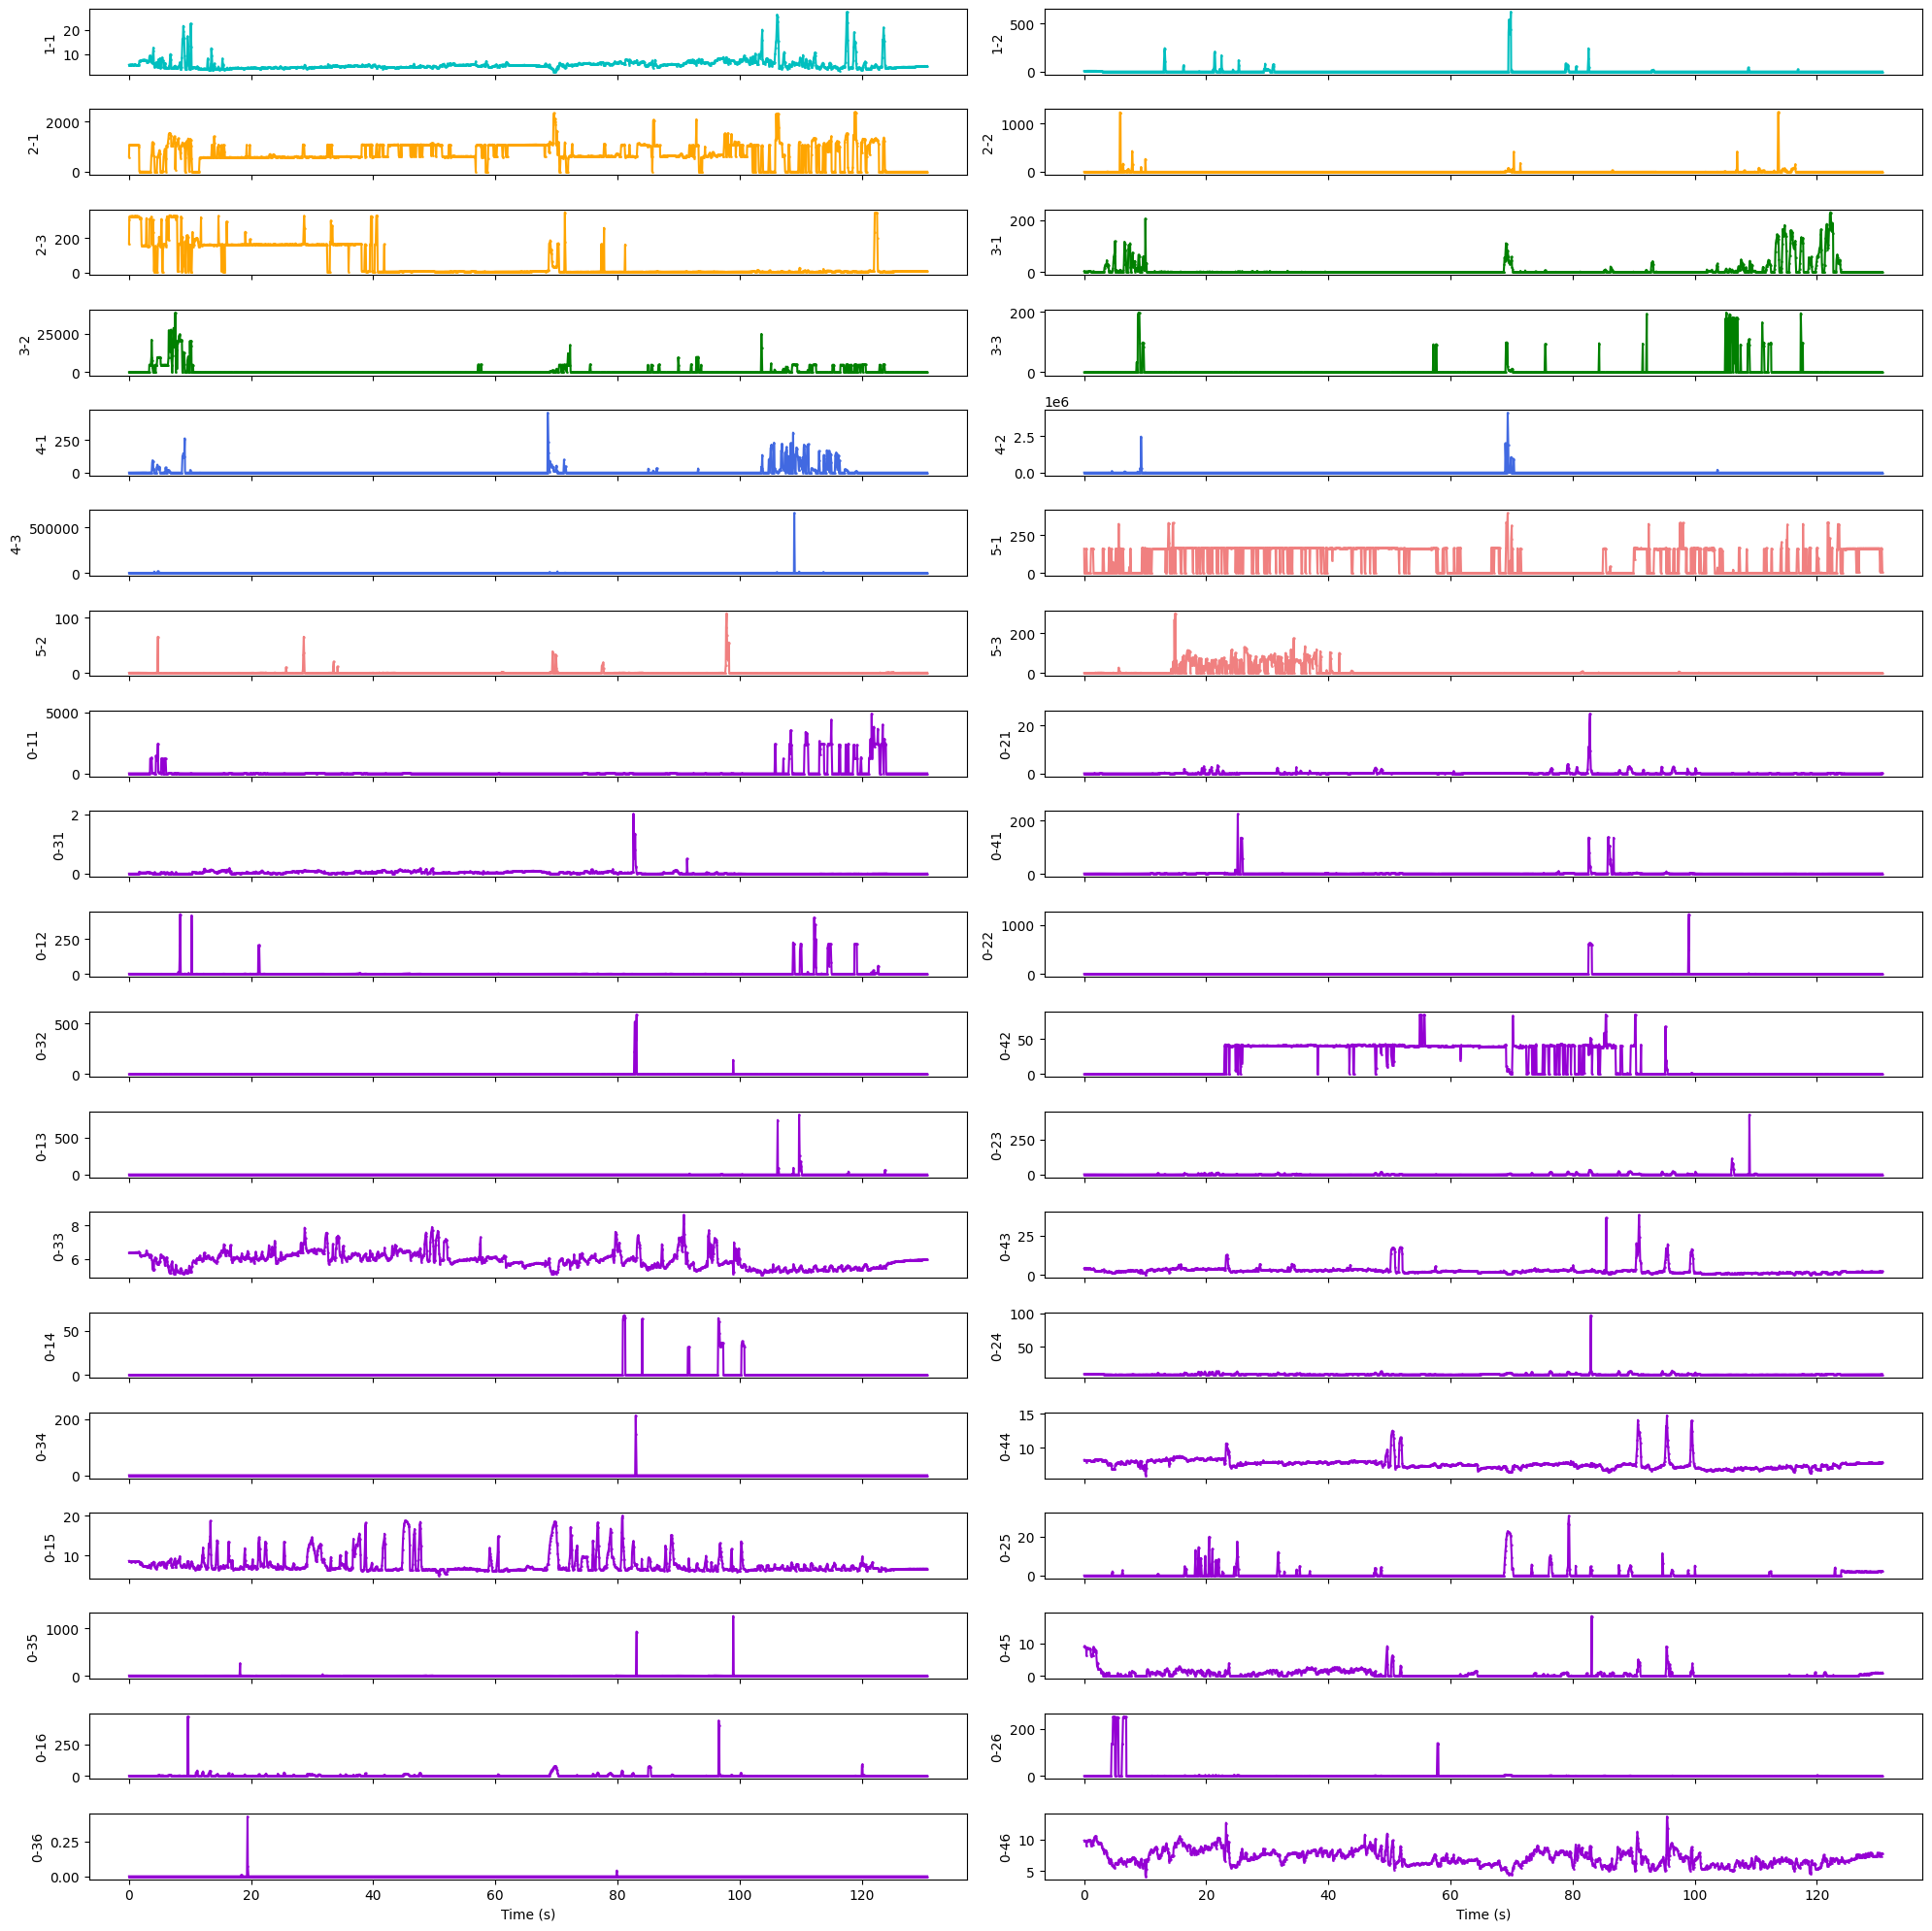

In [7]:
# 创建一个包含38个子图的图形对象
# fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, 
#       ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20, 
#       ax21, ax22, ax23, ax24, ax25, ax26, ax27, ax28, ax29, ax30,
#       ax31, ax32, ax33, ax34, ax35, ax36, ax37, ax38) = plt.subplots(19, 2, figsize=(20, 20), sharex=True)
fig, ax = plt.subplots(19, 2, figsize=(20, 20), sharex=True)

# 在每个子图上绘制曲线
ax[0,0].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["1-1"].mean(axis=(1, 2)), marker="^", linestyle='-', color='c', markersize=1)
ax[0,1].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["1-2"].mean(axis=(1, 2)), marker="^", linestyle='-', color='c', markersize=1)

ax[1,0].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["2-1"].mean(axis=(1, 2)), marker="^", linestyle='-', color='orange', markersize=1)
ax[1,1].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["2-2"].mean(axis=(1, 2)), marker="^", linestyle='-', color='orange', markersize=1)
ax[2,0].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["2-3"].mean(axis=(1, 2)), marker="^", linestyle='-', color='orange', markersize=1)

ax[2,1].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["3-1"].mean(axis=(1, 2)), marker="^", linestyle='-', color='green', markersize=1)
ax[3,0].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["3-2"].mean(axis=(1, 2)), marker="^", linestyle='-', color='green', markersize=1)
ax[3,1].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["3-3"].mean(axis=(1, 2)), marker="^", linestyle='-', color='green', markersize=1)

ax[4,0].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["4-1"].mean(axis=(1, 2)), marker="^", linestyle='-', color='royalblue', markersize=1)
ax[4,1].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["4-2"].mean(axis=(1, 2)), marker="^", linestyle='-', color='royalblue', markersize=1)
ax[5,0].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["4-3"].mean(axis=(1, 2)), marker="^", linestyle='-', color='royalblue', markersize=1)

ax[5,1].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["5-1"].mean(axis=(1, 2)), marker="^", linestyle='-', color='lightcoral', markersize=1)
ax[6,0].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["5-2"].mean(axis=(1, 2)), marker="^", linestyle='-', color='lightcoral', markersize=1)
ax[6,1].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["5-3"].mean(axis=(1, 2)), marker="^", linestyle='-', color='lightcoral', markersize=1)

ax[7,0].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-11"].mean(axis=(1, 2)), marker="^", linestyle='-', color='darkviolet', markersize=1)
ax[7,1].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-21"].mean(axis=(1, 2)), marker="^", linestyle='-', color='darkviolet', markersize=1)
ax[8,0].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-31"].mean(axis=(1, 2)), marker="^", linestyle='-', color='darkviolet', markersize=1)
ax[8,1].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-41"].mean(axis=(1, 2)), marker="^", linestyle='-', color='darkviolet', markersize=1)

ax[9,0].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-12"].mean(axis=(1, 2)), marker="^", linestyle='-', color='darkviolet', markersize=1)
ax[9,1].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-22"].mean(axis=(1, 2)), marker="^", linestyle='-', color='darkviolet', markersize=1)
ax[10,0].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-32"].mean(axis=(1, 2)), marker="^", linestyle='-', color='darkviolet', markersize=1)
ax[10,1].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-42"].mean(axis=(1, 2)), marker="^", linestyle='-', color='darkviolet', markersize=1)

ax[11,0].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-13"].mean(axis=(1, 2)), marker="^", linestyle='-', color='darkviolet', markersize=1)
ax[11,1].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-23"].mean(axis=(1, 2)), marker="^", linestyle='-', color='darkviolet', markersize=1)
ax[12,0].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-33"].mean(axis=(1, 2)), marker="^", linestyle='-', color='darkviolet', markersize=1)
ax[12,1].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-43"].mean(axis=(1, 2)), marker="^", linestyle='-', color='darkviolet', markersize=1)

ax[13,0].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-14"].mean(axis=(1, 2)), marker="^", linestyle='-', color='darkviolet', markersize=1)
ax[13,1].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-24"].mean(axis=(1, 2)), marker="^", linestyle='-', color='darkviolet', markersize=1)
ax[14,0].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-34"].mean(axis=(1, 2)), marker="^", linestyle='-', color='darkviolet', markersize=1)
ax[14,1].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-44"].mean(axis=(1, 2)), marker="^", linestyle='-', color='darkviolet', markersize=1)

ax[15,0].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-15"].mean(axis=(1, 2)), marker="^", linestyle='-', color='darkviolet', markersize=1)
ax[15,1].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-25"].mean(axis=(1, 2)), marker="^", linestyle='-', color='darkviolet', markersize=1)
ax[16,0].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-35"].mean(axis=(1, 2)), marker="^", linestyle='-', color='darkviolet', markersize=1)
ax[16,1].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-45"].mean(axis=(1, 2)), marker="^", linestyle='-', color='darkviolet', markersize=1)

ax[17,0].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-16"].mean(axis=(1, 2)), marker="^", linestyle='-', color='darkviolet', markersize=1)
ax[17,1].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-26"].mean(axis=(1, 2)), marker="^", linestyle='-', color='darkviolet', markersize=1)
ax[18,0].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-36"].mean(axis=(1, 2)), marker="^", linestyle='-', color='darkviolet', markersize=1)
ax[18,1].plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-46"].mean(axis=(1, 2)), marker="^", linestyle='-', color='darkviolet', markersize=1)


ax[0,0].set_ylabel("1-1")
ax[0,1].set_ylabel("1-2")

ax[1,0].set_ylabel("2-1")
ax[1,1].set_ylabel("2-2")
ax[2,0].set_ylabel("2-3")

ax[2,1].set_ylabel("3-1")
ax[3,0].set_ylabel("3-2")
ax[3,1].set_ylabel("3-3")

ax[4,0].set_ylabel("4-1")
ax[4,1].set_ylabel("4-2")
ax[5,0].set_ylabel("4-3")

ax[5,1].set_ylabel("5-1")
ax[6,0].set_ylabel("5-2")
ax[6,1].set_ylabel("5-3")

ax[7,0].set_ylabel("0-11")
ax[7,1].set_ylabel("0-21")
ax[8,0].set_ylabel("0-31")
ax[8,1].set_ylabel("0-41")

ax[9,0].set_ylabel("0-12")
ax[9,1].set_ylabel("0-22")
ax[10,0].set_ylabel("0-32")
ax[10,1].set_ylabel("0-42")

ax[11,0].set_ylabel("0-13")
ax[11,1].set_ylabel("0-23")
ax[12,0].set_ylabel("0-33")
ax[12,1].set_ylabel("0-43")

ax[13,0].set_ylabel("0-14")
ax[13,1].set_ylabel("0-24")
ax[14,0].set_ylabel("0-34")
ax[14,1].set_ylabel("0-44")

ax[15,0].set_ylabel("0-15")
ax[15,1].set_ylabel("0-25")
ax[16,0].set_ylabel("0-35")
ax[16,1].set_ylabel("0-45")

ax[17,0].set_ylabel("0-16")
ax[17,1].set_ylabel("0-26")
ax[18,0].set_ylabel("0-36")
ax[18,1].set_ylabel("0-46")

ax[18,0].set_xlabel("Time (s)")
ax[18,1].set_xlabel("Time (s)")

# 调整子图之间的间距
plt.tight_layout()

#plt.savefig('all blocks.png', dpi=300)
# 显示图形
plt.show()

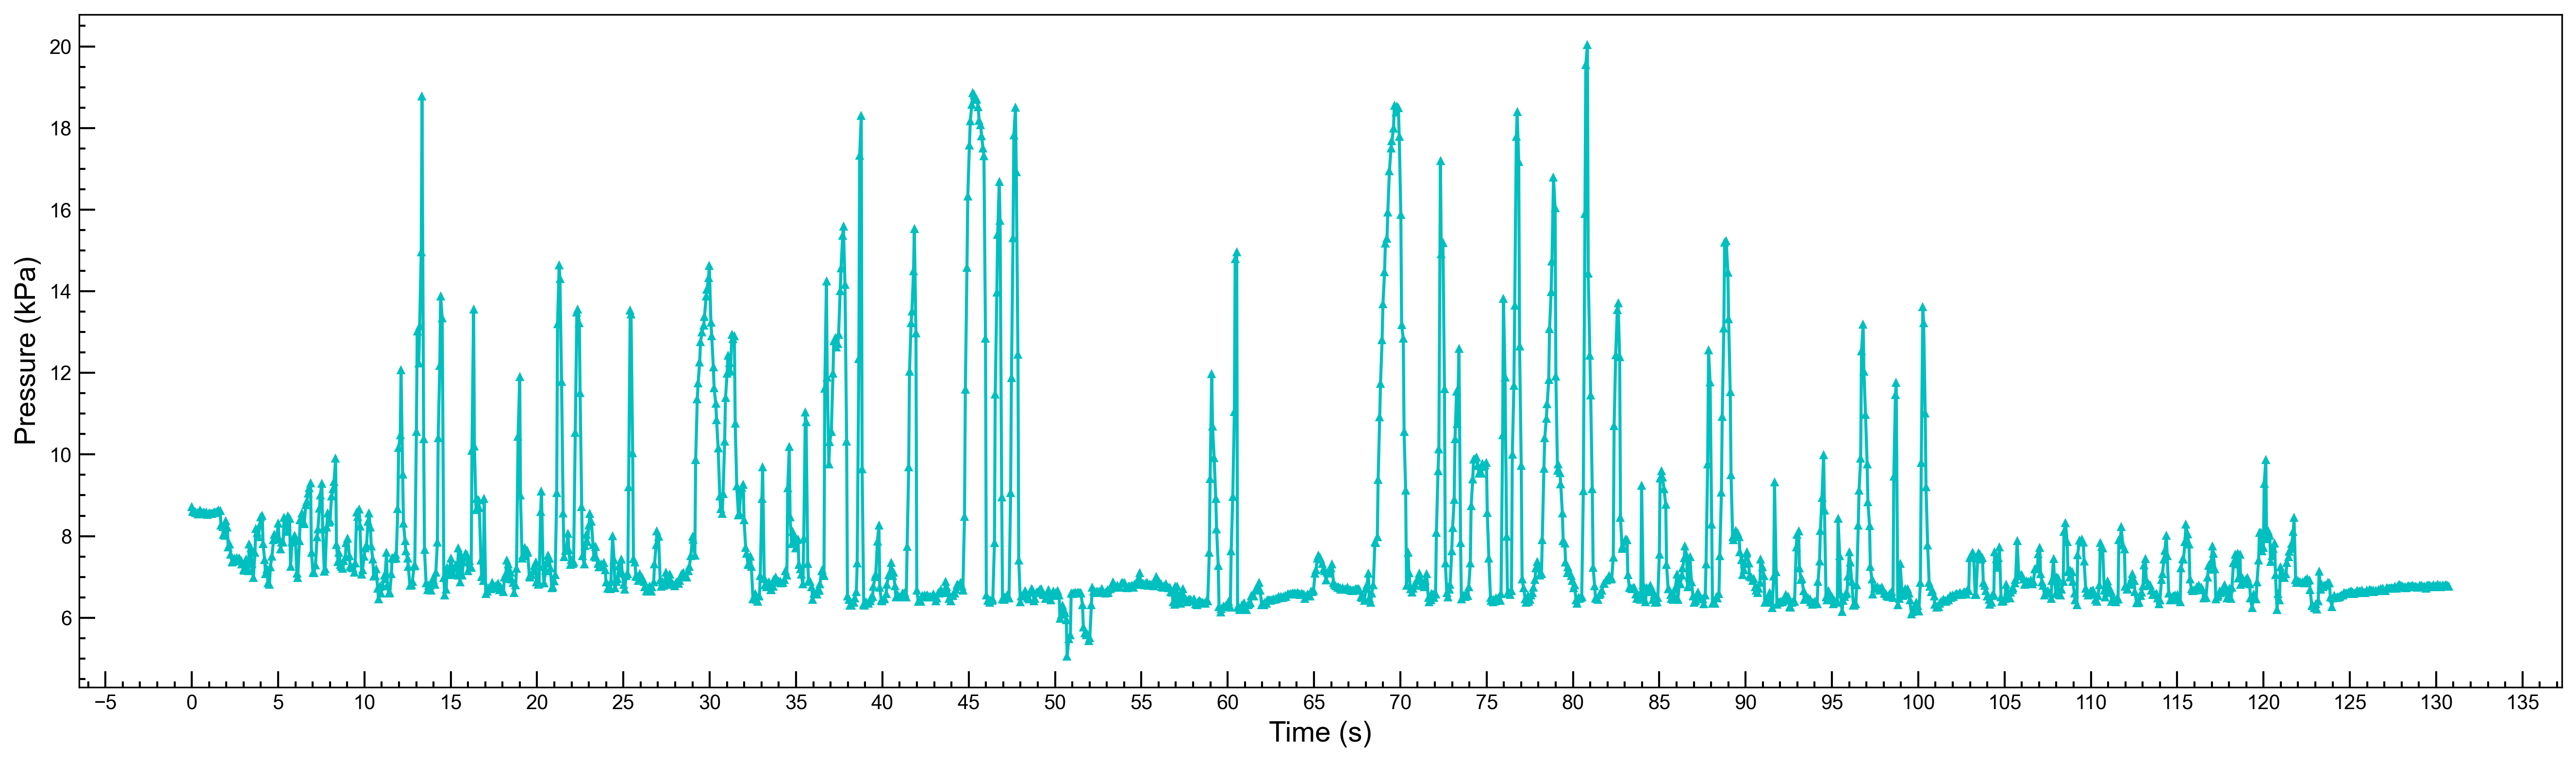

In [9]:
########单个block的平均压力##########
plt.figure(figsize=(22, 6))
plt.rcParams["figure.dpi"] = 300  
axes = plt.subplot()
plt.xlabel('Time (s)', fontfamily='Arial', fontsize=14) 
plt.ylabel('Pressure (kPa)', fontfamily='Arial', fontsize=14) 
ax=plt.gca() #ax为两条坐标轴的实例
#刻度值字体设置
labels = ax.get_xticklabels()+ ax.get_yticklabels()
[label.set_fontname('Arial') for label in labels]


#plt.xlim(85.3,86.1) #横轴，时间：秒  #捏动作3

axes.minorticks_on()  # 显示副刻度线
axes.tick_params(axis="both", which="major", direction="in", width=1, length=8) # 设置主刻度线参数
axes.tick_params(axis="both", which="minor", direction="in", width=1, length=3) # 设置副刻度线参数

ax=plt.gca()
#设置x,y 的主刻度定位器
#ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_major_locator(MultipleLocator(5))
#ax.yaxis.set_major_locator(MultipleLocator(0.2))
#设置 X 轴上的副刻度线之间的间隔
axes.xaxis.set_minor_locator(MultipleLocator(1)) 

total_palm_pressure = (splited_pressure["0-11"].mean(axis=(1, 2)) + splited_pressure["0-21"].mean(axis=(1, 2)) +
                      splited_pressure["0-31"].mean(axis=(1, 2)) + splited_pressure["0-41"].mean(axis=(1, 2)) +
                      splited_pressure["0-12"].mean(axis=(1, 2)) + splited_pressure["0-22"].mean(axis=(1, 2)) +
                      splited_pressure["0-32"].mean(axis=(1, 2)) + splited_pressure["0-42"].mean(axis=(1, 2)) +
                      splited_pressure["0-13"].mean(axis=(1, 2)) + splited_pressure["0-23"].mean(axis=(1, 2)) +
                      splited_pressure["0-33"].mean(axis=(1, 2)) + splited_pressure["0-43"].mean(axis=(1, 2)) +
                      splited_pressure["0-14"].mean(axis=(1, 2)) + splited_pressure["0-24"].mean(axis=(1, 2)) +
                      splited_pressure["0-34"].mean(axis=(1, 2)) + splited_pressure["0-44"].mean(axis=(1, 2)) +
                      splited_pressure["0-15"].mean(axis=(1, 2)) + splited_pressure["0-25"].mean(axis=(1, 2)) +
                      splited_pressure["0-35"].mean(axis=(1, 2)) + splited_pressure["0-45"].mean(axis=(1, 2)) +
                      splited_pressure["0-16"].mean(axis=(1, 2)) + splited_pressure["0-26"].mean(axis=(1, 2)) +
                      splited_pressure["0-36"].mean(axis=(1, 2)) + splited_pressure["0-46"].mean(axis=(1, 2)))/24

plt.plot((timestamp - timestamp[0]) * 1e-9, splited_pressure["0-15"].mean(axis=(1, 2)), marker="^", linestyle='-', color='c', markersize=3)

plt.show()

In [19]:
#限定时间等于10-20秒的范围（注：原始时间单位为ns）
#indices = np.where( (20 * 1e9 > timestamp_corrected) &  (timestamp_corrected > 10 * 1e9) ) # select indices and save
#plt.plot(timestamp_corrected[indices], splited_pressure["2-1"][indices].mean(axis=(1, 2)), marker="o", linestyle='-', color='c', markersize=3)

In [10]:
####计算参与揉海绵的block的压力并保存

#待分析的block标号（14个手指指节）
BlockList = ['1-1', '1-2', '2-1', '2-2', '2-3', '3-1', '3-2', '3-3', '4-1', '4-2', '4-3', '5-1', '5-2', '5-3']
#采样的时间点（根据2-1的波形得到，共18个时间点）
SampleTime = np.array([12, 13.25, 19, 21.25, 25.5, 30, 31.5, 37.75, 38.75, 42, 45.25, 46.75, 47.75, 59, 60.5, 69.75, 80.75, 89])

##step1:先求所有手指指节的压力
Pressure_finger_arr = np.zeros((14, 18))
for i in range(14):
    for j in range(18):
        indices = np.where(timestamp_corrected > SampleTime[j] * 1e9)[0][0:1]  #取满足条件的第一个值
        Pressure_finger_arr[i][j] = splited_pressure[BlockList[i]][indices].mean(axis=(1, 2))

##step2:再求所有手掌的压力 
Pressure_palm_arr = np.zeros((1, 18))

for p in range(1):
    for q in range(18):
        indices = np.where(timestamp_corrected > SampleTime[q] * 1e9)[0][0:1]  #取满足条件的第一个值
        Pressure_palm_arr[p][q] = (splited_pressure["0-11"][indices].mean(axis=(1, 2)) + splited_pressure["0-21"][indices].mean(axis=(1, 2)) +
                                  splited_pressure["0-31"][indices].mean(axis=(1, 2)) + splited_pressure["0-41"][indices].mean(axis=(1, 2)) +
                                  splited_pressure["0-12"][indices].mean(axis=(1, 2)) + splited_pressure["0-22"][indices].mean(axis=(1, 2)) +
                                  splited_pressure["0-32"][indices].mean(axis=(1, 2)) + splited_pressure["0-42"][indices].mean(axis=(1, 2)) +
                                  splited_pressure["0-13"][indices].mean(axis=(1, 2)) + splited_pressure["0-23"][indices].mean(axis=(1, 2)) +
                                  splited_pressure["0-33"][indices].mean(axis=(1, 2)) + splited_pressure["0-43"][indices].mean(axis=(1, 2)) +
                                  splited_pressure["0-14"][indices].mean(axis=(1, 2)) + splited_pressure["0-24"][indices].mean(axis=(1, 2)) +
                                  splited_pressure["0-34"][indices].mean(axis=(1, 2)) + splited_pressure["0-44"][indices].mean(axis=(1, 2)) +
                                  splited_pressure["0-15"][indices].mean(axis=(1, 2)) + splited_pressure["0-25"][indices].mean(axis=(1, 2)) +
                                  splited_pressure["0-35"][indices].mean(axis=(1, 2)) + splited_pressure["0-45"][indices].mean(axis=(1, 2)) +
                                  splited_pressure["0-16"][indices].mean(axis=(1, 2)) + splited_pressure["0-26"][indices].mean(axis=(1, 2)) +
                                  splited_pressure["0-36"][indices].mean(axis=(1, 2)) + splited_pressure["0-46"][indices].mean(axis=(1, 2)))/24
        
Total_pressure_array = np.vstack((Pressure_finger_arr, Pressure_palm_arr))  #一行代表：一个block在不同采样时间点的结果


#print(Total_pressure_array.shape)
# 创建DataFrame对象
df = pd.DataFrame(Total_pressure_array.T)  #为了后续计算相关性，把一列存放一个block的数据，故转置
# 保存到csv文件
df.to_csv('Total_pressure_array(20230718擀面).csv', index=True)



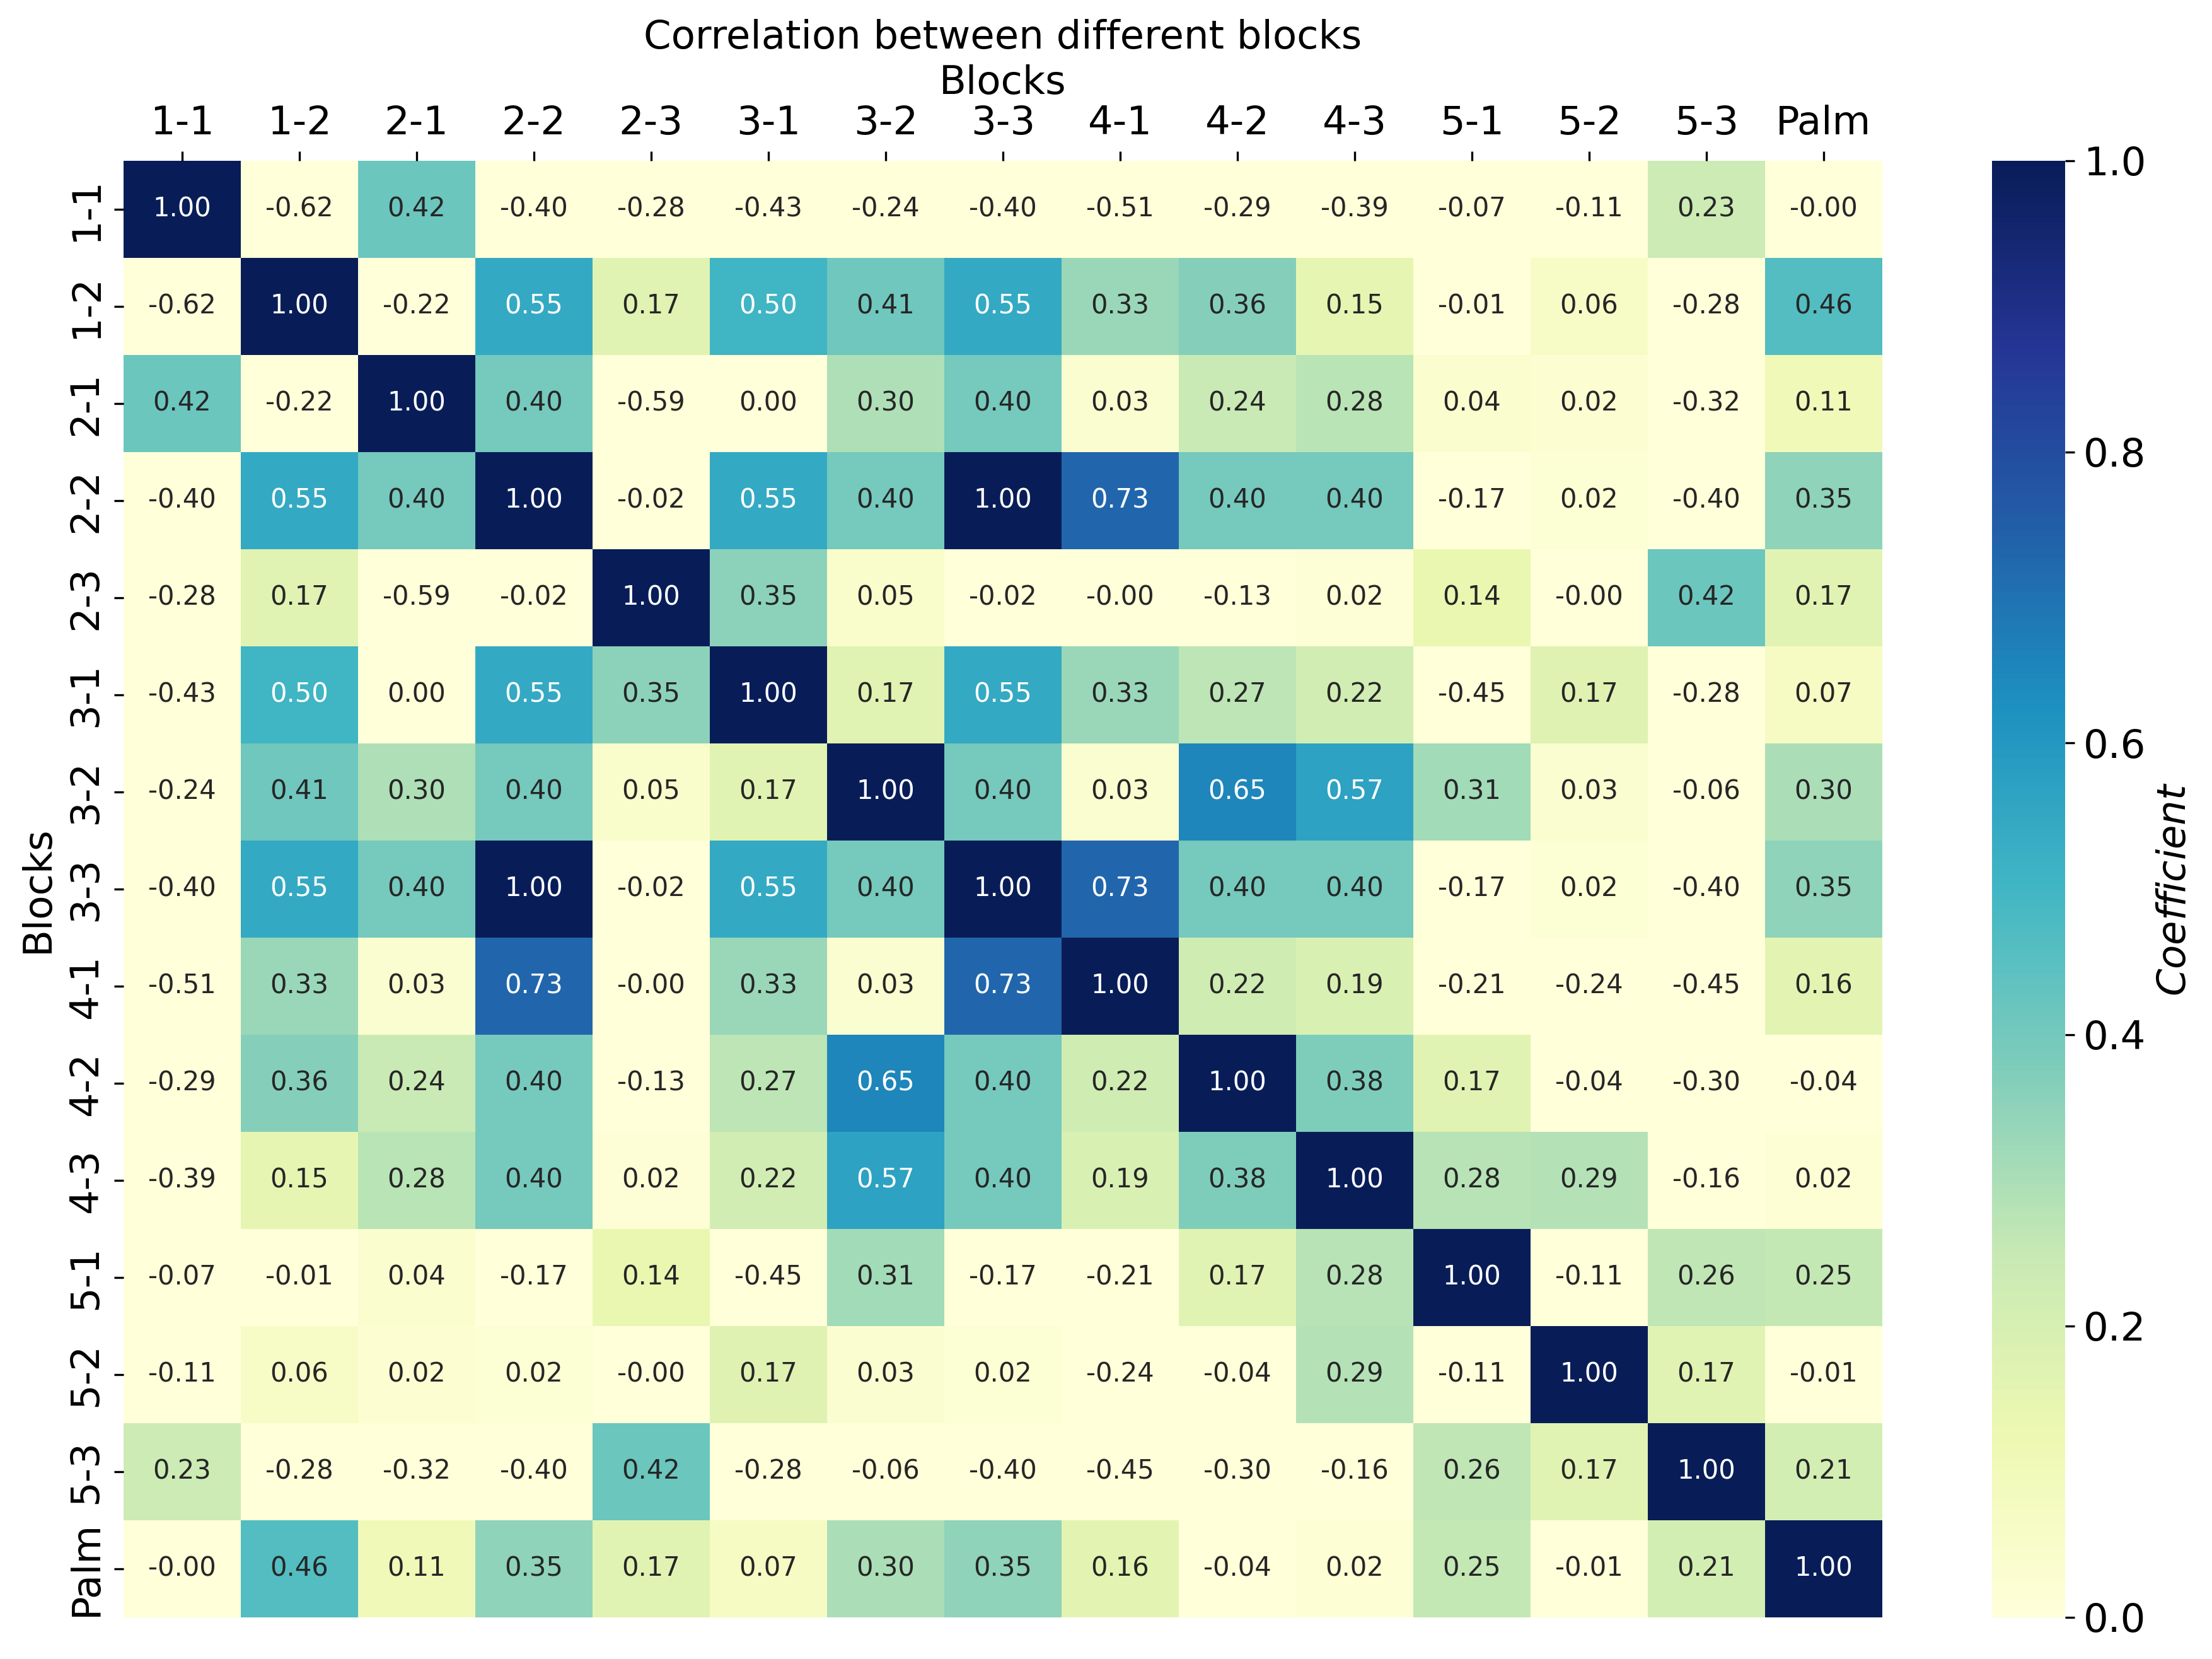

In [11]:
###计算不同blocks在抓软海绵时的Spearman斯皮尔曼相关性
corr = df.corr(method='spearman')
#print(corr)

# 绘制相关系数热力图
plt.subplots(figsize = (15,10))
ax = sns.heatmap(corr, vmin=0, vmax=1, cmap="YlGnBu", annot=True, fmt='.2f', xticklabels=['1-1', '1-2', '2-1', '2-2', '2-3', '3-1', '3-2', '3-3', '4-1', '4-2', '4-3', '5-1', '5-2', '5-3', 'Palm'], yticklabels=['1-1', '1-2', '2-1', '2-2', '2-3', '3-1', '3-2', '3-3', '4-1', '4-2', '4-3', '5-1', '5-2', '5-3', 'Palm'])

# 设置格式
mpl.rcParams['font.family'] = 'Arial'  #全局字体

font = {'family': 'Arial',
        'color': 'k',
        'weight': 'normal',
        'size': 15}

ax.tick_params(left=True, right=False, top=True, bottom=False, labelleft=True, labelright=False, labeltop=True, labelbottom=False)  #设置轴线位置
plt.xlabel('Blocks',fontsize=15, color='k') 
plt.ylabel('Blocks',fontsize=15, color='k') 
ax.xaxis.set_label_position('top')
plt.xticks(fontsize=15) #x轴刻度的字体大小（文本包含在pd_data中了）
plt.yticks(fontsize=15) 
plt.title('Correlation between different blocks',fontsize=15) #图片标题文本和字体大小
#设置colorbar的刻度字体大小
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
#设置colorbar的label文本和字体大小
cbar = ax.collections[0].colorbar
cbar.set_label(r'$Coefficient$',fontdict=font)

# 保存热力图
plt.savefig('heatmap.png', dpi=600, bbox_inches='tight')

# 显示图形
plt.show()
